In [136]:
import numpy as np
from matplotlib import pyplot as plt

import os
import glob
import cv2

In [137]:
root_dir = "asl_alphabet_train"
image_data = {}

In [138]:
for class_folder in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_folder)
    if os.path.isdir(class_path):
        class_images = []
        for image_file in glob.glob(os.path.join(class_path, "*.jpg")):  # Change the file extension as needed
            class_images.append(image_file)
        image_data[class_folder] = class_images

In [139]:
for class_name, images in image_data.items():
    print(f"Class: {class_name}\tCount: {len(images)}")

Class: A	Count: 3000
Class: B	Count: 3000
Class: C	Count: 3000
Class: D	Count: 3000
Class: del	Count: 3000
Class: E	Count: 3000
Class: F	Count: 3000
Class: G	Count: 3000
Class: H	Count: 3000
Class: I	Count: 3000
Class: J	Count: 3000
Class: K	Count: 3000
Class: L	Count: 3000
Class: M	Count: 3000
Class: N	Count: 3000
Class: nothing	Count: 3000
Class: O	Count: 3000
Class: P	Count: 3000
Class: Q	Count: 3000
Class: R	Count: 3000
Class: S	Count: 3000
Class: space	Count: 3000
Class: T	Count: 3000
Class: U	Count: 3000
Class: V	Count: 3000
Class: W	Count: 3000
Class: X	Count: 3000
Class: Y	Count: 3000
Class: Z	Count: 3000


In [140]:
max_images_per_class = 110  # Set the maximum number of images per class
classNumber = 0

images = []
classes = []

for class_name, image_paths in image_data.items():
    class_count = 0  # Initialize a counter for the current class
    for image_path in image_paths:
        if isinstance(image_path, str) and os.path.exists(image_path):
            image = cv2.imread(image_path, 0)
            image = cv2.resize(image, (28, 28), interpolation= cv2.INTER_LINEAR)

            if image is not None:  # Check if the image was successfully loaded
                images.append(image)
                classes.append(classNumber)
                class_count += 1
                
            if class_count >= max_images_per_class:
                break  # Stop loading images for the current class

    classNumber += 1

In [141]:
import random

# Combine the two lists into pairs
combined_lists = list(zip(classes, images))

# Shuffle the pairs
random.shuffle(combined_lists)

# Unzip the shuffled pairs back into separate lists
classes, images = zip(*combined_lists)

In [142]:
classes = np.array(classes)
images = np.array(images)

In [143]:
images = images.reshape(-1, 784)

In [144]:
m, n = images.shape
print(m, n)

3190 784


In [145]:
Y_data= classes.T
X_data = images.T

X_data = X_data / 255.

In [146]:
X_train = X_data[0:m]
y_train = Y_data[0:m]

X_test = X_data[3000:m]
y_test = Y_data[3000:m]

In [147]:
_,m_train = X_train.shape

In [148]:
print(X_train)
print(y_train)

[[0.34509804 0.45882353 0.4627451  ... 0.40784314 0.3372549  0.49803922]
 [0.35294118 0.45490196 0.45098039 ... 0.41568627 0.34901961 0.50980392]
 [0.37647059 0.45098039 0.44705882 ... 0.42352941 0.35686275 0.50196078]
 ...
 [0.58039216 0.69803922 0.59607843 ... 0.45490196 0.53333333 0.65098039]
 [0.59215686 0.68235294 0.61568627 ... 0.52156863 0.5372549  0.6627451 ]
 [0.50588235 0.65882353 0.63137255 ... 0.62352941 0.56078431 0.70196078]]
[17 15 12 ... 10 18  5]


In [149]:
def init_params():
    W1 = np.random.rand(29, 784) - 0.5
    b1 = np.random.rand(29, 1) - 0.5
    W2 = np.random.rand(29, 29) - 0.5
    b2 = np.random.rand(29, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [150]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 100 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [151]:
W1, b1, W2, b2 = gradient_descent(X_train, y_train, 0.10, 10000)

Iteration:  0
[14 14 14 ... 14 14 14] [17 15 12 ... 10 18  5]
0.034482758620689655
Iteration:  100
[28 28  9 ...  9 28 28] [17 15 12 ... 10 18  5]
0.08213166144200627
Iteration:  200
[28 28 19 ...  9 28 28] [17 15 12 ... 10 18  5]
0.0877742946708464
Iteration:  300
[28 28  5 ...  9 28  5] [17 15 12 ... 10 18  5]
0.1206896551724138
Iteration:  400
[28 28  5 ...  9 28  5] [17 15 12 ... 10 18  5]
0.13479623824451412
Iteration:  500
[28 28  1 ...  9 28  5] [17 15 12 ... 10 18  5]
0.13981191222570533
Iteration:  600
[28 28  1 ...  6 28  5] [17 15 12 ... 10 18  5]
0.1592476489028213
Iteration:  700
[28 28  1 ...  6 28  5] [17 15 12 ... 10 18  5]
0.17335423197492164
Iteration:  800
[28 28  1 ...  6 28  5] [17 15 12 ... 10 18  5]
0.18495297805642633
Iteration:  900
[28  2  2 ...  6 28  5] [17 15 12 ... 10 18  5]
0.1981191222570533
Iteration:  1000
[28  2  2 ...  6 28  5] [17 15 12 ... 10 18  5]
0.19655172413793104
Iteration:  1100
[28 15  2 ...  6 28  5] [17 15 12 ... 10 18  5]
0.2322884012539

In [152]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [18]
Label:  17


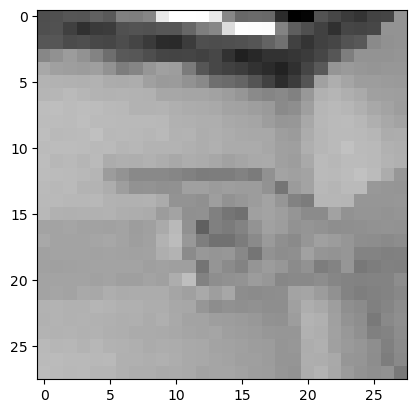

Prediction:  [15]
Label:  15


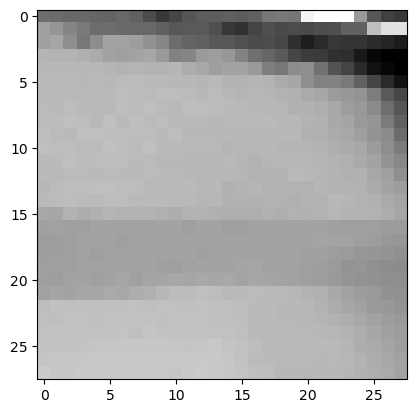

Prediction:  [12]
Label:  12


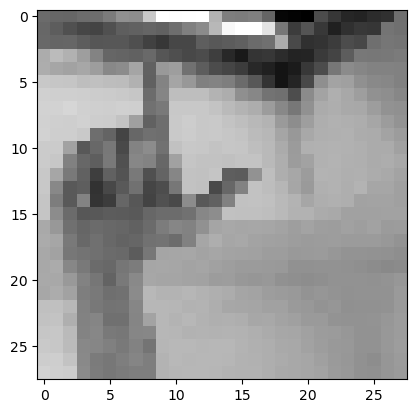

Prediction:  [12]
Label:  12


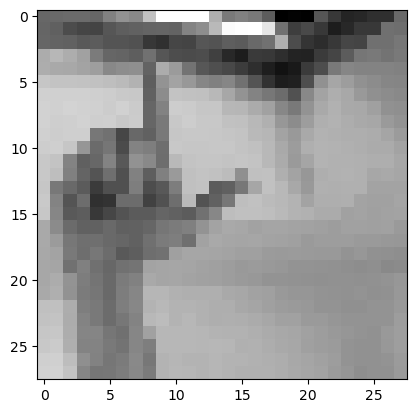

In [153]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [157]:
dev_predictions = make_predictions(X_train, W1, b1, W2, b2)
get_accuracy(dev_predictions, y_train)

[18 15 12 ... 10 18  5] [17 15 12 ... 10 18  5]


0.8288401253918495

In [158]:
print("Weights 1:", W1)

Weights 1: [[-0.14049653 -0.22923569 -0.28852517 ... -0.1699382   0.19401001
   0.44693938]
 [ 0.22359526  0.35268676 -0.40224386 ...  0.1454271   0.05958856
  -0.34500929]
 [-0.02969314 -0.4729476  -0.45963944 ...  0.28218915 -0.39766008
  -0.49117763]
 ...
 [ 0.25913098  0.11672824  0.19635501 ... -0.2802663   0.00972061
   0.05523156]
 [-0.49265397  0.47842455 -0.01222777 ... -0.36954584  0.12568616
   0.13911869]
 [-0.37585352  0.03228755 -0.02299315 ... -0.37625444 -0.46965773
  -0.26084134]]


In [159]:
print("Bias 1:", b1)

Bias 1: [[-1.54068824]
 [-1.18146228]
 [-0.97827146]
 [-1.67552348]
 [-0.73016822]
 [-0.77505145]
 [-1.25933849]
 [-1.41864774]
 [-1.25622051]
 [-0.98591999]
 [-1.26675463]
 [-1.04442789]
 [-1.33007528]
 [-1.70272052]
 [-0.86662551]
 [-1.63807408]
 [-1.40100377]
 [-1.09747897]
 [-1.50799362]
 [-1.00445711]
 [-1.38815287]
 [-1.07115502]
 [-0.83922797]
 [-1.61718985]
 [-1.0102999 ]
 [-0.79153498]
 [-1.0012449 ]
 [-1.71260228]
 [-0.99525391]]


In [160]:
print("Weights 2:", W2)

Weights 2: [[-3.20873189e-01 -8.19495796e-02  2.86643504e-01 -4.39338846e-01
  -3.75176175e-02  1.28210672e-02  1.22283051e+00  6.31889588e-01
   1.44967197e-01  4.84534192e-01  1.27885412e-01  2.06367397e+00
  -4.33134929e-01 -8.03183927e-02 -4.25060136e-01 -1.14327881e+00
   6.64348096e-02  3.76301669e-01  4.48980870e-01  5.14169069e-01
   2.45882061e-01 -2.79200908e-01 -7.25513702e-01  1.48940193e+00
   2.10051950e-01 -4.41184054e-02 -1.40025385e-01 -3.44882886e-01
  -4.32954767e-01]
 [-2.55108770e-01  3.98593769e-01  4.99281400e-01 -6.13017929e-02
   3.88560690e-01  4.51159291e-01 -9.74424990e-01 -5.78347960e-01
  -3.77518689e-01  2.79215202e-01 -4.10577579e-01 -3.64493784e-01
  -2.15371911e+00 -7.35264964e-04 -1.51712288e-01 -8.63017045e-01
  -8.66843003e-02 -2.10894607e-01 -3.39536785e-01 -4.31484510e-01
  -2.17286130e-01 -8.10066447e-02 -9.10516878e-01  2.32982476e+00
  -2.59190931e-01  3.70882151e-01  4.64822880e-01 -2.56532810e-01
  -1.32604856e-01]
 [ 6.48979686e-02 -2.667955

In [161]:
print("Bias 2:", b1)

Bias 2: [[-1.54068824]
 [-1.18146228]
 [-0.97827146]
 [-1.67552348]
 [-0.73016822]
 [-0.77505145]
 [-1.25933849]
 [-1.41864774]
 [-1.25622051]
 [-0.98591999]
 [-1.26675463]
 [-1.04442789]
 [-1.33007528]
 [-1.70272052]
 [-0.86662551]
 [-1.63807408]
 [-1.40100377]
 [-1.09747897]
 [-1.50799362]
 [-1.00445711]
 [-1.38815287]
 [-1.07115502]
 [-0.83922797]
 [-1.61718985]
 [-1.0102999 ]
 [-0.79153498]
 [-1.0012449 ]
 [-1.71260228]
 [-0.99525391]]
